# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [4]:
shift = 200
ylog=np.log(data_train_raw['loss']+shift)
## ymean=ylog.mean()
## ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()-ymean
data_train_raw['loss_g']=(ylog-ymean)/ystd
# data_train_raw['loss_g']=ylog

In [5]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: 0.390118205749
Std of log1py: 0.114240274464
Lower clipping bound: 0.047397382357
Upper clipping bound: 0.732839029142
Shape of cleaned data: (187995, 133)


In [6]:
# # rescale cleaned data
# ymean=data_train_raw['loss_g'].min()
# ystd=data_train_raw['loss_g'].max()
# data_train_raw['loss_g']=(ylog-ymean)/(ystd-ymean)

In [7]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

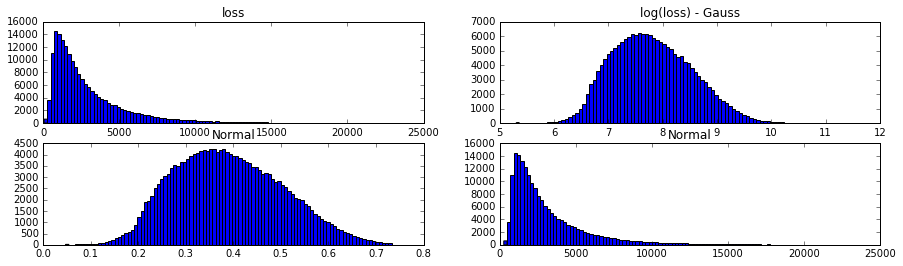

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

In [9]:
# continuous variables with very rare values:
# f130, f100, f123, f112 top 4 variables
# f101, f124, f118, f122, f121
# f117, f113, f120, f119, f110
# f129, f114, f126, f103, f127, f125, f111, f91, f116, f128, f82, f83, f80, f79, f81, f108

# Data preparation - labeling encoder

In [10]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [11]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313541, 130)
(313541, 116) of which are categorical
(313541, 14) of which are continuous


In [12]:
# # features with meaningful level values
# # cat1, cat2, cat4, cat5, cat6, cat9, cat10, cat11, cat12, cat13, cat23, cat36, cat38, cat50, cat72, cat73, cat75, cat79, cat80,
# # cat81, cat83, cat84, cat86, cat91, cat92, cat93, cat94, cat95, cat97, cat98, cat99, cat100, cat101, cat103, cat104, cat105,
# # cat106, cat107, cat108, cat110, cat111, cat112, cat113, cat115, cat116
# catList = ['cat1', 'cat2', 'cat4', 'cat5', 'cat6', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat23', 'cat25', 'cat26', 'cat36', 'cat37', 'cat38', \
#            'cat50','cat53', 'cat72', 'cat73', 'cat75', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat86', 'cat87', 'cat91', 'cat92', 'cat93', \
#            'cat94', 'cat95', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', \
#            'cat108', 'cat109', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116']

# catToDel = [col for col in dataCatAll.columns if col not in catList]
# dataCatAll.drop(catToDel, axis=1,inplace=True)

In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
# LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
        
# dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
# dataCatAll.head()

In [15]:
features = dataCatAll.columns[0:]
dataCatAll_2 = dataCatAll[features]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll_2[feat] = pd.factorize(dataCatAll_2[feat], sort=True)[0]
dataCatAll_2.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,46,28,2,19,57,0,14,287
1,0,1,0,0,0,0,0,0,1,1,...,10,10,34,67,0,22,39,0,14,94
2,0,1,0,0,1,0,0,0,1,1,...,5,0,2,87,0,28,6,0,8,167
3,1,1,0,1,0,0,0,0,1,0,...,10,10,34,69,2,39,5,0,14,88
4,0,1,0,1,0,0,0,0,1,1,...,6,1,67,51,2,50,39,0,10,63


#  Data preparation - cat variables

In [16]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# for col in dataCatAll.columns:
#     if (col.find('cat') !=-1):
# #        print(col)
#         dataCatAll[col]=le.fit_transform(dataCatAll[col])
# #         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# #         le.classes_ = np.append(le.classes_, '<unknown>')
# #         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
# print(dataCatAll.columns)


In [17]:
# dataCatAll.head()

In [18]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll_2 = mms.fit_transform(dataCatAll_2)

In [19]:
print(x_catAll_2.shape)
x_catAll_2

(313541, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.82947977],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.2716763 ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.48265896],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.89595376],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.25433526],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.20231214]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [20]:
# # one-hot-encoding the categorical features
# enc = preprocessing.OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# Transform and rescale continuous features

In [21]:
# from sklearn.preprocessing import PolynomialFeatures as PolyF
# polyf = PolyF(interaction_only=True,include_bias=False)
# dataFltAll_poly = polyf.fit_transform(dataFltAll)

In [22]:
# # dataFltAll = dataFltAll_poly
# # dataFltAll.shape
# mms_1 = MinMaxScaler()
# # dataFltAll_poly = mms_1.fit_transform(dataFltAll_poly[:,14:])
# dataFltAll_poly = np.log1p(dataFltAll_poly[:,14:])
# dataFltAll_poly

In [23]:
# dataFltAll_poly.shape

In [24]:
# from scipy import stats
# col = 'cont1'
# dataFltAll[col]= stats.boxcox(dataFltAll[col].values,0.5)
# col = 'cont2'
# dataFltAll[col]= np.tan(dataFltAll[col])
# col = 'cont4'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.2)
# col = 'cont5'
# dataFltAll[col]= np.log(dataFltAll[col])
# col = 'cont6'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.5)
# col = 'cont7'
# dataFltAll[col]= np.log(dataFltAll[col])
# col = 'cont8'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.4)
# col = 'cont9'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.4)
# col = 'cont10'
# dataFltAll[col]= np.tanh(dataFltAll[col]+1)
# col = 'cont11'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.4)
# col = 'cont12'
# dataFltAll[col]= stats.boxcox(dataFltAll[col],0.4)
# col = 'cont13'
# dataFltAll[col]=np.abs(dataFltAll[col] - np.mean(dataFltAll[col]))
# col = 'cont14'
# dataFltAll[col]=np.abs(dataFltAll[col] - np.mean(dataFltAll[col]))

In [25]:
# from sklearn.preprocessing import MinMaxScaler
mms_2 = MinMaxScaler()
for col in dataFltAll.columns:
    dataFltAll[col+'cos'] = np.cos(dataFltAll[col])
    dataFltAll[col+'sin'] = np.sin(dataFltAll[col])
    dataFltAll[col] = np.log(dataFltAll[col])

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [26]:
dataFltAll.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cont10cos,cont10sin,cont11cos,cont11sin,cont12cos,cont12sin,cont13cos,cont13sin,cont14cos,cont14sin
count,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,3.135410e+05,...,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000,313541.000000
mean,-0.793610,-0.805377,-0.803790,-0.806929,-0.806026,-0.804883,-0.788220,-0.801632,-0.792280,-inf,...,0.863483,0.469407,0.861596,0.463039,0.861817,0.462756,0.860941,0.462880,0.858230,0.463495
std,0.541286,0.582509,0.513831,0.452570,0.414217,0.452793,0.360389,0.403358,0.438153,NaN,...,0.094279,0.158636,0.104843,0.179598,0.104841,0.179267,0.107945,0.181304,0.110801,0.190621
min,-11.042922,-6.768863,-5.939252,-1.732052,-1.268892,-4.367493,-2.666385,-1.440202,-9.433484,-inf,...,0.544520,0.000000,0.541360,0.035314,0.541577,0.036224,0.549948,0.000228,0.663845,0.177621
25%,-1.061056,-1.026332,-1.087782,-1.116713,-1.268892,-1.090332,-1.047396,-1.145830,-1.024516,-1.009009e+00,...,0.813971,0.356557,0.778249,0.305974,0.778141,0.303530,0.771263,0.310537,0.748702,0.290412
50%,-0.742791,-0.587379,-0.638676,-0.792113,-0.862115,-0.818835,-0.824441,-0.818574,-0.817691,-7.739452e-01,...,0.895524,0.445014,0.897291,0.441440,0.895035,0.445995,0.934641,0.355592,0.918305,0.395875
75%,-0.469569,-0.383076,-0.455353,-0.427600,-0.441121,-0.422276,-0.526469,-0.472278,-0.564068,-4.782939e-01,...,0.934274,0.580905,0.952040,0.627956,0.952822,0.628090,0.950561,0.636517,0.956902,0.662906
max,-0.015139,-0.147742,-0.057363,-0.044949,-0.016461,-0.002842,0.000000,-0.017350,-0.004611,-5.032643e-03,...,1.000000,0.838748,0.999376,0.840791,0.999344,0.840651,1.000000,0.835199,0.984099,0.747870


# Merge all the features

In [27]:
# x_catAll_2.shape
# x_fltAll.shape
# x_Train

In [28]:
# # split x_train and x_test
# x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
# x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:],x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
# y_Train = labelSs.values

# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# # split x_train and x_test
# x_Train = sp.sparse.hstack((x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:],dataFltAll_poly[0:len(labelSs),:]))
# x_Test = sp.sparse.hstack((x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:],dataFltAll_poly[len(labelSs):,:]))
# y_Train = labelSs.values

# split x_train and x_test
# x_data_raw = sp.sparse.hstack((x_catAll_2,sp.sparse.csr_matrix(dataFltAll.as_matrix())))
# #PCA
# from sklearn.decomposition import PCA
# n_components = 60
# pca = PCA(n_components)
# x_data = pca.fit_transform(x_data_raw.toarray())
# print(sum(pca.explained_variance_ratio_))
# x_Train = x_data[0:len(labelSs),:]
# x_Test = x_data[len(labelSs):,:]
# y_Train = labelSs.values

# # split x_train and x_test
# x_Train = np.hstack((x_catAll_2[0:len(labelSs),:],x_fltAll[0:len(labelSs),:]))
# x_Test = np.hstack((x_catAll_2[len(labelSs):,:],x_fltAll[len(labelSs):,:]))
# y_Train = labelSs.values

In [29]:
# x_catAll_2.shape
# dataFltAll.shape
# dataFltAll_poly.shape

# check the dimension of prepared data

In [30]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 158)
(187995, 158)
(187995,)


# Explore histogram of all features

In [31]:
# x_Train_df = pd.DataFrame(x_Train.toarray(),columns = trainDf.columns)

In [32]:
# catList = [col for col in train_Df.columns[0]] #if col.startswith('cat')]
# for col in catList:
#     fig = plt.figure(figsize = (15,4))
#     fig.suptitle(col)
#     plt.subplot(1,2,1)
#     plt.hist(x_Train_df[col],bins=50, normed=True)
#     plt.subplot(1,2,2)
#     plt.scatter(x_Train_df[col],labelSs)

# splite the training data for validation

In [33]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150396, 158)
(150396,)
(37599, 158)
(37599,)


In [34]:
del x_Train
del y_Train
del x_catAll_2
del dataCatAll
del trainDf
del testDf

# Model Fitting

In [35]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [74]:
testList = ['XGBoostTrees','Ensemble']

### Ridge Regression

In [37]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [38]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (5,20,30,40)
# alphas = [10]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [39]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [40]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [41]:
# from sklearn.linear_model import LassoCV

In [42]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [43]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [44]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [45]:
# from sklearn.ensemble import RandomForestRegressor

In [46]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [47]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [48]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [35]:
import xgboost as xgb

In [36]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

# d_train_xgb = xgb.DMatrix(x_train,label=y_train)
# d_val_xgb = xgb.DMatrix(x_val,label = y_val)
# x_val_xgb = xgb.DMatrix(x_val)
# d_test_xgb = xgb.DMatrix(x_Test)

In [37]:
# custom obj function follows:
# https://www.kaggle.com/extremin/allstate-claims-severity/xgb1113/discussion
num_boost_round = 2950

def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con =2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0,'eta':0.05,'min_child_weight':0}
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1116, 2950 rounds - log1p+sin+cos+sqrt cont features
# params = {'eval_metric':'mae','max_depth':12,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.06,'min_child_weight':0,'subsample':0.8}# 1117, 2950 rounds - log1p cont features

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_boost_round,watchlist,obj=logregobj)
# gbt.cv = xgb.cv(params, d_train_xgb,num_boost_round)

[0]	eval-mae:0.131728	train-mae:0.130872
[1]	eval-mae:0.129648	train-mae:0.128808
[2]	eval-mae:0.127628	train-mae:0.126808
[3]	eval-mae:0.125674	train-mae:0.124869
[4]	eval-mae:0.123774	train-mae:0.122987
[5]	eval-mae:0.121931	train-mae:0.121157
[6]	eval-mae:0.120144	train-mae:0.119385
[7]	eval-mae:0.118403	train-mae:0.117659
[8]	eval-mae:0.116719	train-mae:0.115992
[9]	eval-mae:0.115088	train-mae:0.114372
[10]	eval-mae:0.113502	train-mae:0.112805
[11]	eval-mae:0.111967	train-mae:0.111278
[12]	eval-mae:0.11048	train-mae:0.109798
[13]	eval-mae:0.109036	train-mae:0.10837
[14]	eval-mae:0.107636	train-mae:0.106982
[15]	eval-mae:0.10628	train-mae:0.105633
[16]	eval-mae:0.104963	train-mae:0.104324
[17]	eval-mae:0.10369	train-mae:0.103057
[18]	eval-mae:0.102455	train-mae:0.101831
[19]	eval-mae:0.101261	train-mae:0.100647
[20]	eval-mae:0.100099	train-mae:0.099497
[21]	eval-mae:0.098972	train-mae:0.098377
[22]	eval-mae:0.097877	train-mae:0.097293
[23]	eval-mae:0.096822	train-mae:0.096246
[24]	e

In [39]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

NameError: name 'mean_absolute_error' is not defined

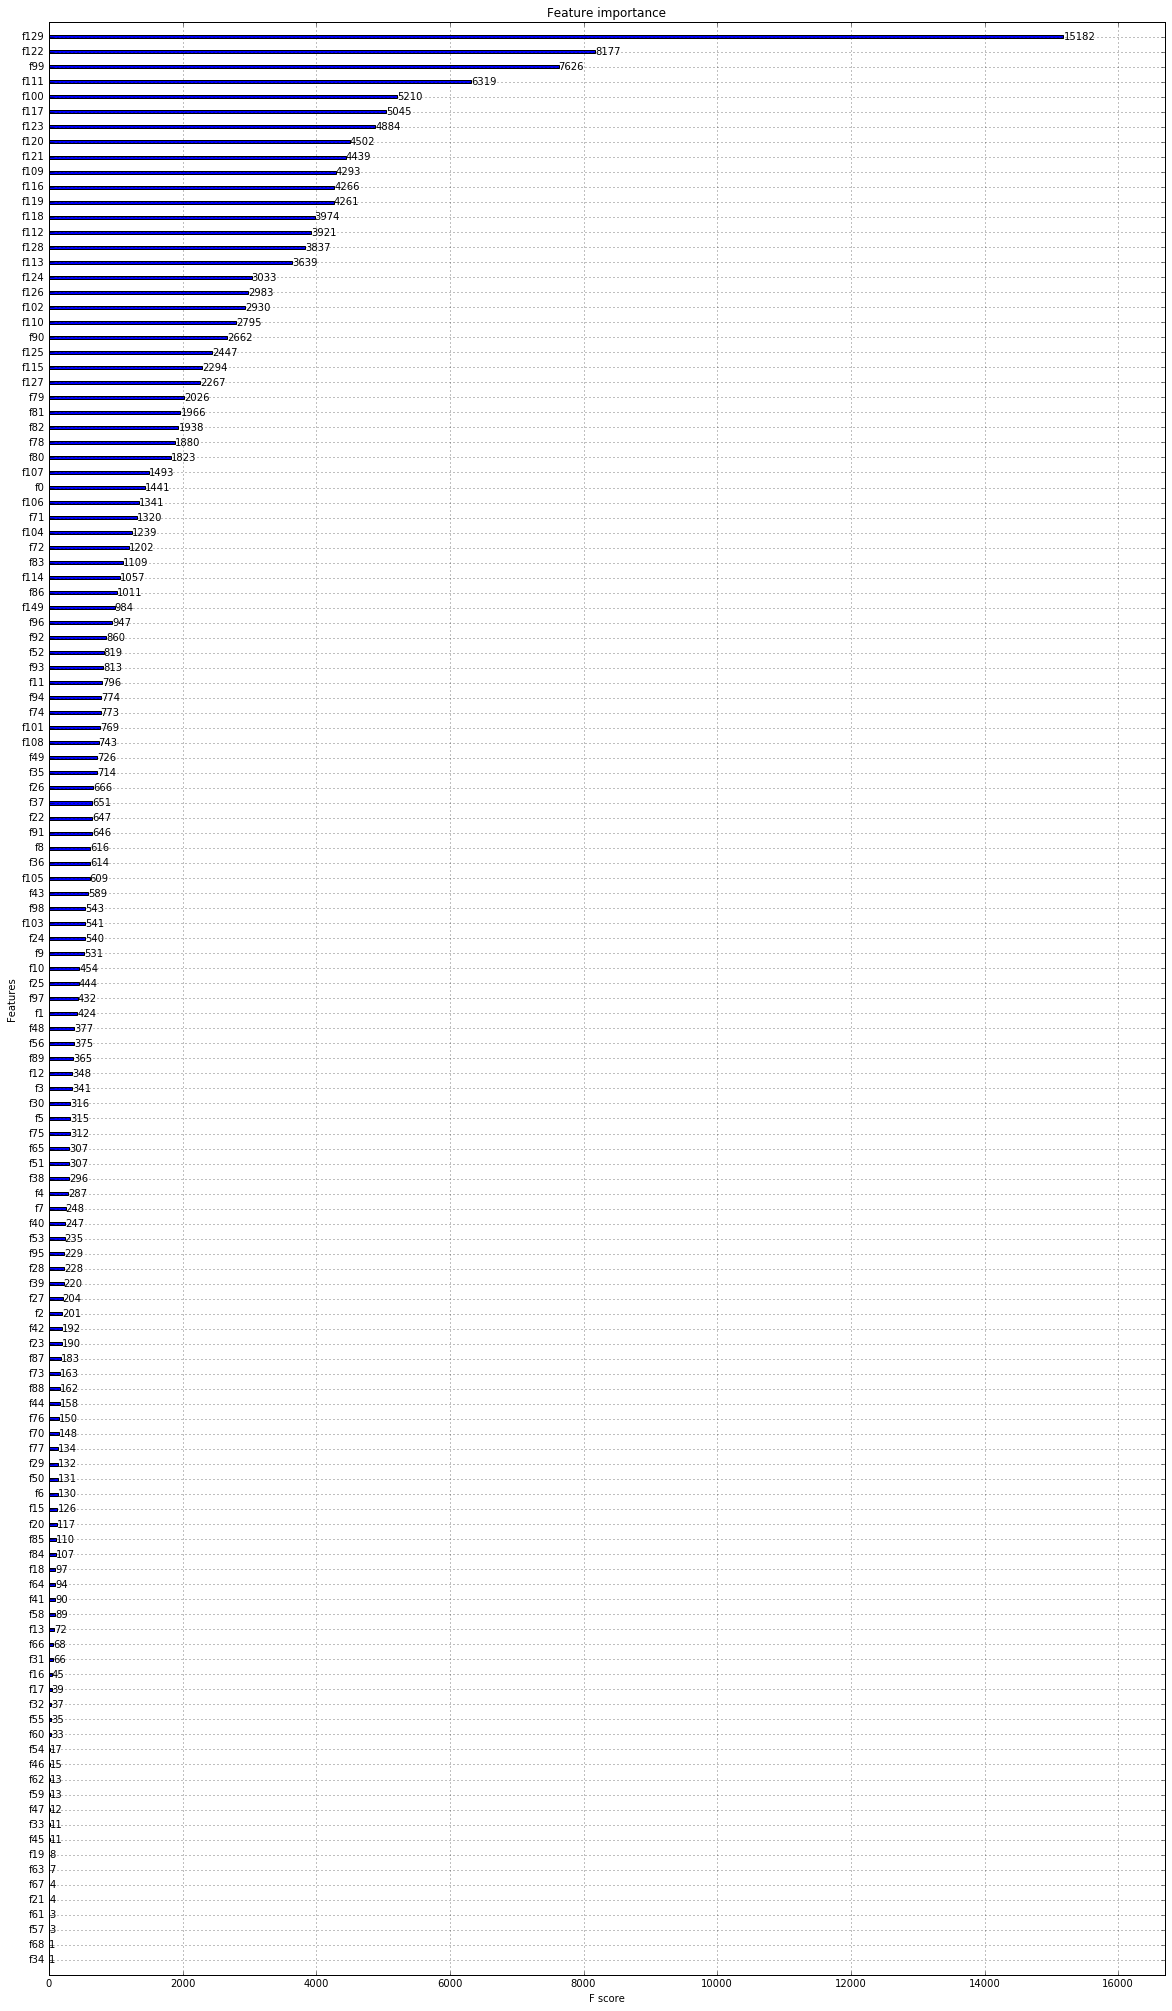

In [55]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() )

In [56]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [57]:
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.linear_model import Ridge

In [70]:
# # n_estimators = [7,15,30, 60, 90, 120]
# # n_estimators = [10,20,30,40]
# n_estimators = [6]
# base_estimator = Ridge(alpha = 40)
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
# #     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
#     tmpAdReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         AdReg = tmpAdReg
#         n_estimator = n_est
#         err = err_i

In [ ]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [ ]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [ ]:
# from sklearn.svm import LinearSVR

In [ ]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [ ]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [59]:
# from sklearn.neural_network import MLPRegressor

In [71]:
# MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
# MLPReg.fit(x_train,y_train)

In [72]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

In [73]:
# y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [63]:
# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


1101.3762319470738

In [64]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))



In [65]:
# remove the shift
y_pred = [y_array-shift for y_array in y_pred];
y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [66]:
y_pred

[array([  1428.75024414,   1994.94433594,  10049.74316406, ...,
          2390.1328125 ,   1076.71936035,   2915.53613281], dtype=float32),
 array([  1428.75024414,   1994.94433594,  10049.74316406, ...,
          2390.1328125 ,   1076.71936035,   2915.53613281], dtype=float32)]

In [67]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

IndexError: list index out of range

In [79]:
from sklearn.externals import joblib
joblib.dump([gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

['../output/models-raw-features-rescale-loss-shift.pkl']

# Evaluate errors

In [ ]:
x_val_df = pd.DataFrame(data=x_val.toarray(), columns = trainDf.columns)
x_val_df.head()

In [ ]:
y_val_df = pd.DataFrame(data = y_val,columns = ['loss_g'])
y_val_df.head()

In [ ]:
y_pred_df = pd.DataFrame()
Y_pred_err_df = pd.DataFrame()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(3,2,1)
err_gbt = (lossRestore(y_val,ymean,ystd)-lossRestore(gbt.predict(x_val_xgb),ymean,ystd));
Y_pred_err_df['gbt'] =err_gbt
plt.hist(err_gbt,bins=80);
plt.subplot(3,2,2)
y_pred_df['gbt']=lossRestore(gbt.predict(x_val_xgb),ymean,ystd)
plt.hist(y_pred_df['gbt'],bins=80);

plt.subplot(3,2,3)
err_AdB = (lossRestore(y_val,ymean,ystd)-lossRestore(AdReg.predict(x_val),ymean,ystd));
plt.hist(err_AdB,bins=80);
Y_pred_err_df['AdB'] =err_AdB
plt.subplot(3,2,4)
y_pred_df['AdB']=lossRestore(AdReg.predict(x_val),ymean,ystd)
plt.hist(y_pred_df['AdB'],bins=80);

plt.subplot(3,2,5)
err_mlp = (lossRestore(y_val,ymean,ystd)-lossRestore(MLPReg.predict(x_val),ymean,ystd));
Y_pred_err_df['mlp'] =err_mlp
plt.hist(err_mlp,bins=80);
plt.subplot(3,2,6)
y_pred_df['mlp']=lossRestore(MLPReg.predict(x_val),ymean,ystd)
plt.hist(y_pred_df['mlp'],bins=80);

In [ ]:
y_pred_df.describe()

In [ ]:
len(y_pred_df[y_pred_df['gbt'].abs()>=5000]['gbt'])
# len(y_pred_df[y_pred_df['gbt'].abs()<5000]['gbt'])

In [ ]:
x_val_large_df = x_val_df[y_pred_df['gbt'].abs()>=1120]
x_val_small_df = x_val_df[y_pred_df['gbt'].abs()<1120]

In [ ]:
catList = [col for col in x_val_large_df.columns if col.startswith('cat')]
for col in catList:
    fig = plt.figure(figsize = (15,4))
    fig.suptitle(col)
    plt.subplot(1,2,1)
    plt.hist(x_val_large_df[col],bins=40, normed=True)
#     ax.set_title(col+' '+'large err')
    plt.subplot(1,2,2)
    plt.hist(x_val_small_df[col],bins=40, normed=True)
#     plt.Axes.set_title(col+' '+'small err')

In [ ]:
# features with meaningful level values
# cat1, cat2, cat4, cat5, cat6, cat9, cat10, cat11, cat12, cat13, cat23, cat36, cat38, cat50, cat72, cat73, cat75, cat79, cat80,
# cat81, cat83, cat84, cat86, cat91, cat92, cat93, cat94, cat95, cat97, cat98, cat99, cat100, cat101, cat103, cat104, cat105,
# cat106, cat107, cat108, cat110, cat111, cat112, cat113, cat115, cat116, 

In [ ]:
col = 'cat76'
x_val_large_df.groupby(by=col).count()

In [ ]:
x_val_small_df.groupby(by=col).count()